In [1]:
%matplotlib inline

In [2]:
from ebmdatalab import bq

In [3]:
sql = '''
SELECT
  vmpp.vppid,
  vmpp.nm,
  DATE(tariffprice.date) AS date,
  price_pence,
  CASE tariff_category
    WHEN 1 THEN 'A'
    WHEN 3 THEN 'C'
    WHEN 11 THEN 'M'
    ELSE NULL
  END
  AS tariff_category,
  price_concession_pence
FROM
  dmd.vmpp
INNER JOIN
  dmd.tariffprice
ON
  vmpp.vppid = tariffprice.vmpp
LEFT OUTER JOIN
  dmd.ncsoconcession
ON
  tariffprice.vmpp = ncsoconcession.vmpp AND tariffprice.date = ncsoconcession.date
WHERE tariffprice.date > TIMESTAMP('2014-05-01')  # last five years only
ORDER BY nm, date
'''

# reset_index is required because of a bug in pandas-gbq
# a fix should be released soon
# https://github.com/pydata/pandas-gbq/issues/133
tariffs = bq.cached_read(sql, csv_path='tariffs.csv').reset_index(drop=True)

In [4]:
concession_vppids = set(tariffs[~tariffs['price_concession_pence'].isna()]['vppid'].unique())
tariffs['has_had_concession'] = tariffs['vppid'].isin(concession_vppids)

In [5]:
tariffs.head()

,vppid,nm,date,price_pence,tariff_category,price_concession_pence,has_had_concession
0,29747011000001102,Abatacept 125mg/1ml solution for injection pre...,2018-10-01,120960,C,NaN,False
1,29747011000001102,Abatacept 125mg/1ml solution for injection pre...,2018-11-01,120960,C,NaN,False
2,29747011000001102,Abatacept 125mg/1ml solution for injection pre...,2018-12-01,120960,C,NaN,False
3,29747011000001102,Abatacept 125mg/1ml solution for injection pre...,2019-01-01,120960,C,NaN,False
4,29747011000001102,Abatacept 125mg/1ml solution for injection pre...,2019-02-01,120960,C,NaN,False


In [6]:
def plot_percentiles(tariffs, title):
    pivot = tariffs.pivot(index='vppid', columns='date', values='price_pence').dropna()
    pivot_norm = pivot.div(pivot[pivot.columns[0]], axis='rows')
    percentiles = pivot_norm.quantile([i * 0.01 for i in range(10, 91)])
    percentiles.transpose().plot(title=title, color='b', linewidth=0.2, legend=False, ylim=(0, 10), figsize=(15, 5));

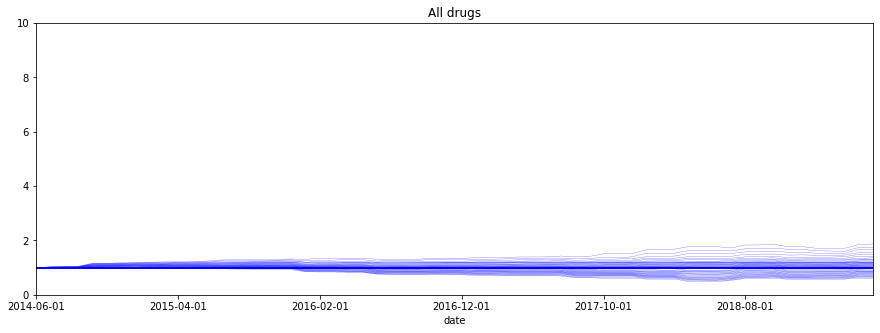

In [7]:
plot_percentiles(tariffs, 'All drugs')

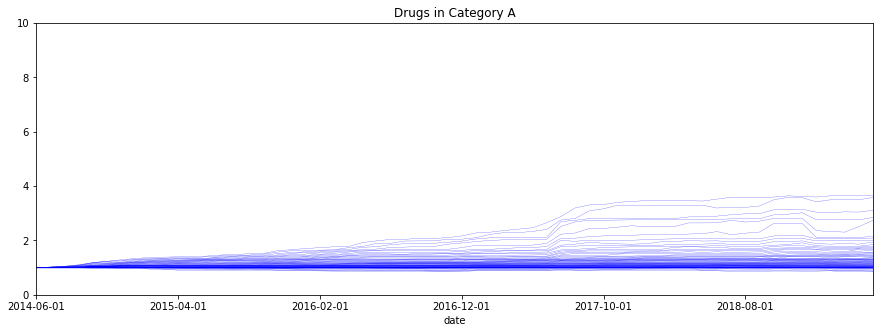

In [8]:
plot_percentiles(tariffs[tariffs['tariff_category'] == 'A'], 'Drugs in Category A')

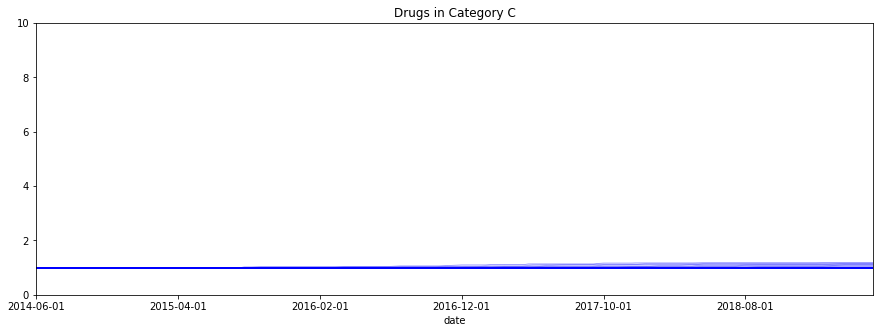

In [9]:
plot_percentiles(tariffs[tariffs['tariff_category'] == 'C'], 'Drugs in Category C')

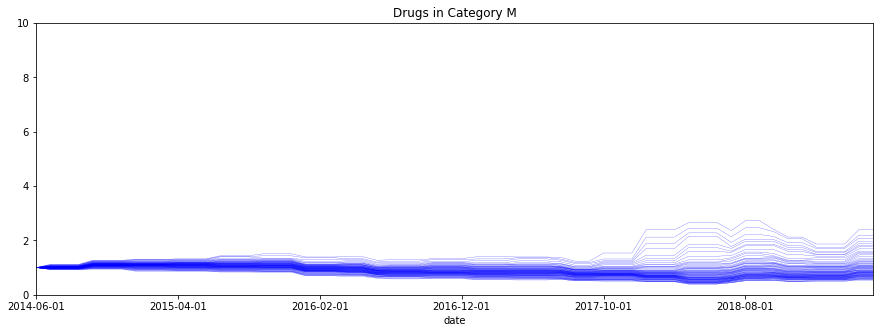

In [10]:
plot_percentiles(tariffs[tariffs['tariff_category'] == 'M'], 'Drugs in Category M')

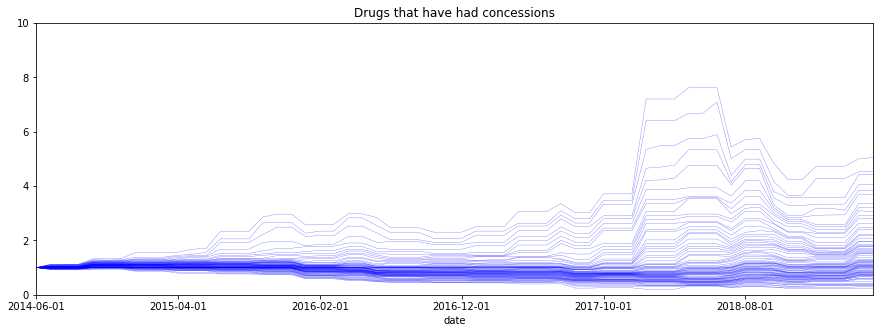

In [11]:
plot_percentiles(tariffs[tariffs['has_had_concession']], 'Drugs that have had concessions')

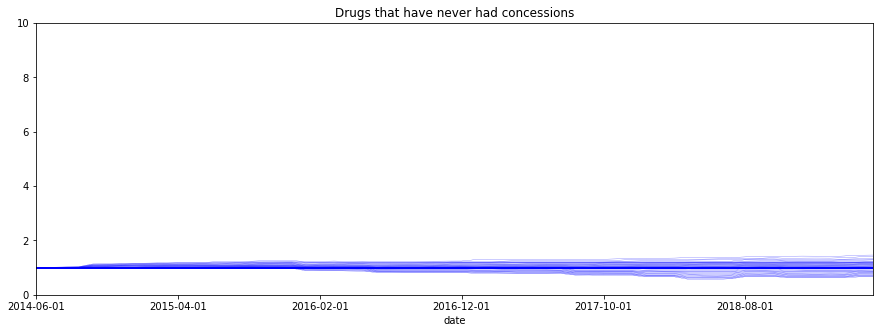

In [12]:
plot_percentiles(tariffs[~tariffs['has_had_concession']], 'Drugs that have never had concessions')